In [160]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import (silhouette_score, silhouette_score, adjusted_rand_score,
                             adjusted_mutual_info_score, completeness_score, homogeneity_score,
                             v_measure_score)
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(X[:, 0], X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

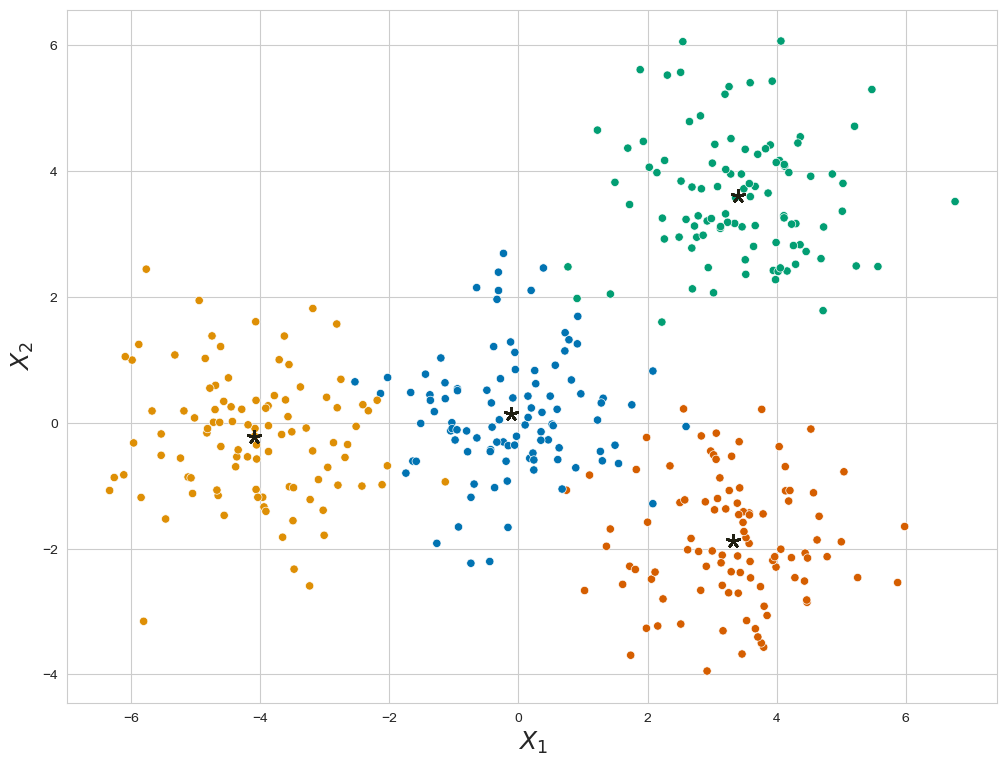

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [10]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        # like we did in fit function
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        dists = np.concatenate(dists, axis=1)
        
        cluster_labels = np.argmin(dists, axis=1)
        
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        return np.sqrt(np.sum(np.square(X - centroid), axis=1)).reshape(-1, 1)
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

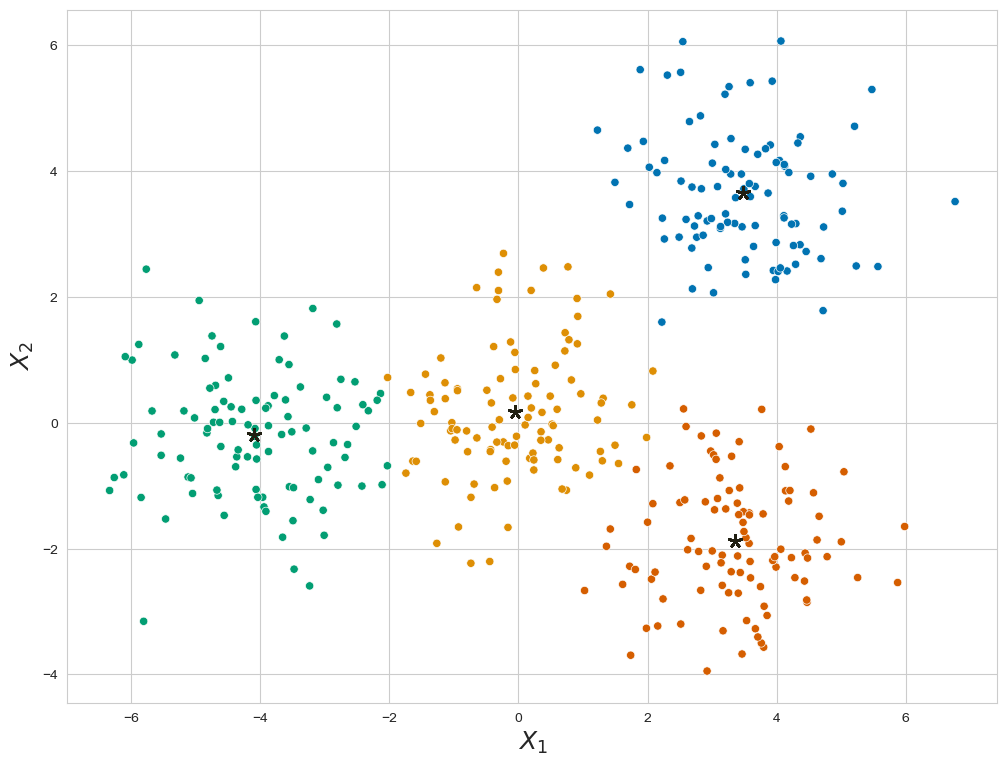

In [11]:
initialization = "random"
iterations = 10

kmeans_random = MyKMeans(n_clusters=4, visualize=True, init=initialization, max_iter=iterations)
kmeans_random.fit(X)
pred_random = kmeans_random.predict(X)

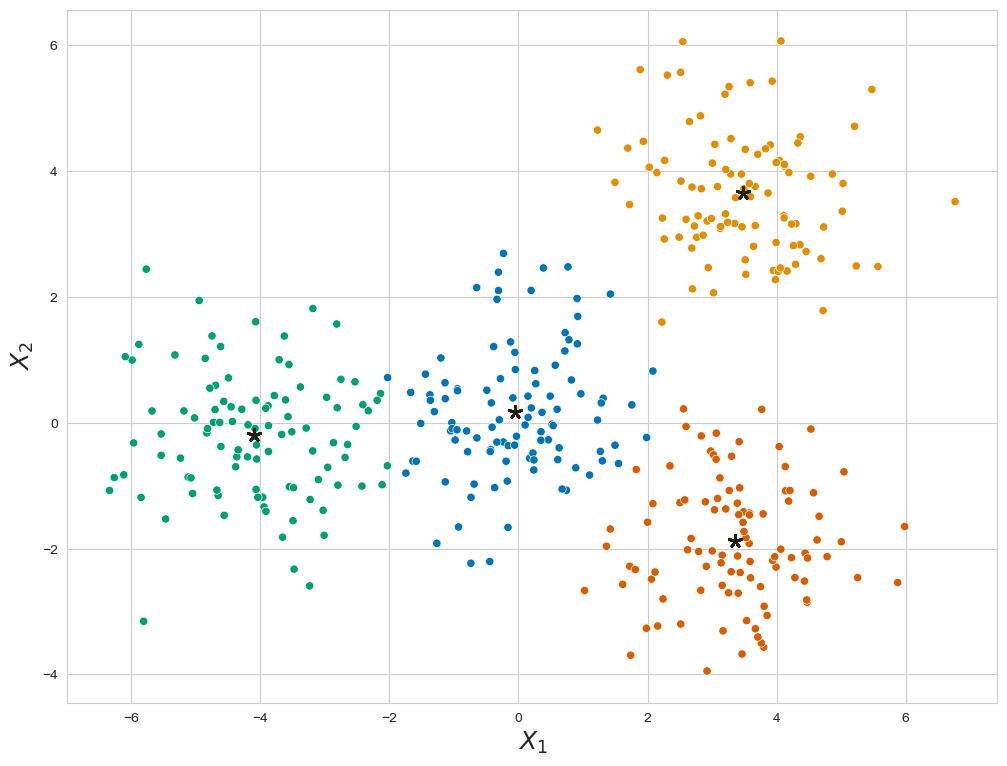

In [12]:
initialization = "sample"
iterations = 10

kmeans_sample = MyKMeans(n_clusters=4, visualize=True, init=initialization, max_iter=iterations)
kmeans_sample.fit(X)
pred_sample = kmeans_sample.predict(X)

As we can see in both cases our centers are plotted inside the zones of high point density. So seems like accuracy should be hight for both predictions. Let's check it out.

We will calculate the following metrics:

* **Rand Index**, which is measuring the similarity of the true and predicted labels, ignoring permutations:

$$\text{RI} = \frac{a + b}{C_2^{n_{samples}}}$$

where a - number of pairs that are in the same clusters in both prediction and true labels; b - number of pairs that are in the different sets in true labels and also in a different clusters in predictions; C - number of all possible pairs.


**Adjusted Rand Index** helps to correct measure according to the probability to get it:

$$\text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\max(\text{RI}) - E[\text{RI}]}$$


* **Mutual information** score that measures the agreement of the predicted and true labels, ignoring permutations.

* **Silhouette Coefficient**, which is taking into account only model predictions and basically comparing how big is interclass distance comparing to the deviations within class. It can be calculated according to the following formula:

$$\frac{a(x) - b(x)}{max(a(x), b(x))}$$

where a is a mean distance between the sample and other samples of the same class; b is a mean distance between sample and all samples in the nearest neighbor cluster.

In [17]:
for pred, name in zip([pred_sample, pred_random], ['random initialization:', 'sample initialization:']):
    print(f'Metrics for {name}:',
          f'mean Silhouette Coefficient: {silhouette_score(X, pred)}',
          f'Adjusted Rand Index: {adjusted_rand_score(true_labels, pred)}',
          f'Adjusted Mutual Information: {adjusted_mutual_info_score(true_labels, pred)}',
          sep='\n')
    print()

Metrics for random initialization::
mean Silhouette Coefficient: 0.5643117184043004
Adjusted Rand Index: 0.9278697796079957
Adjusted Mutual Information: 0.9051395864810661

Metrics for sample initialization::
mean Silhouette Coefficient: 0.5643117184043004
Adjusted Rand Index: 0.9278697796079957
Adjusted Mutual Information: 0.9051395864810662



There is almost no difference between scores for different types of initialization. We can see that the metrics are quite high for both results.

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [123]:
data = load_digits()
X, y = data.data, data.target

In [42]:
X.shape

(1797, 64)

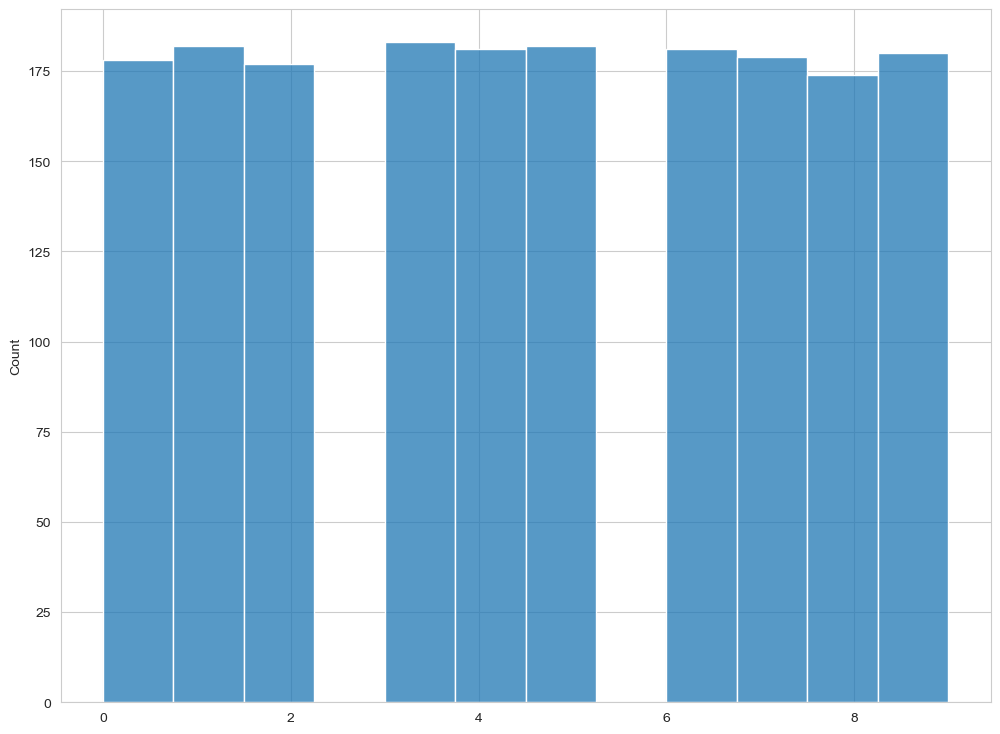

In [50]:
sns.histplot(y);

We have unique class labels from 0 till 9, and classes are equally distributed with approximatelly 175 objects of each.

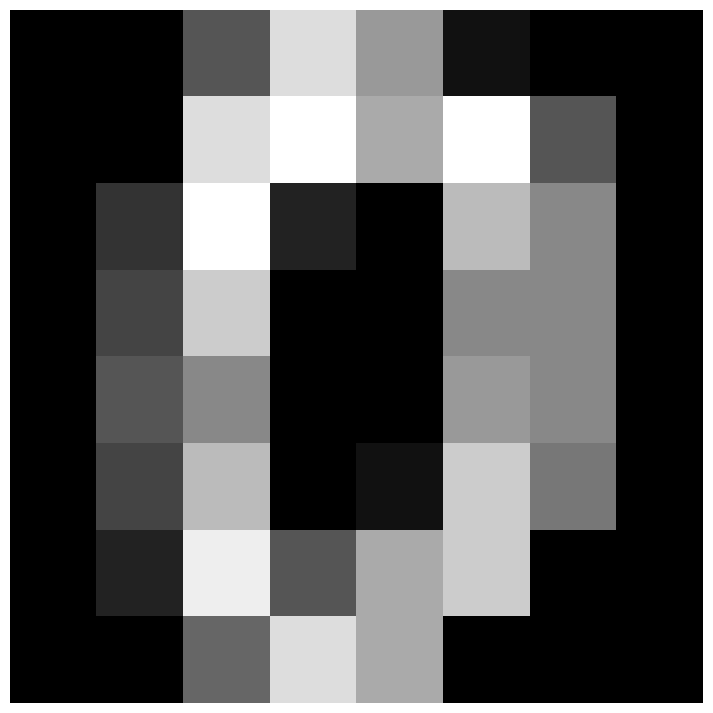

In [41]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

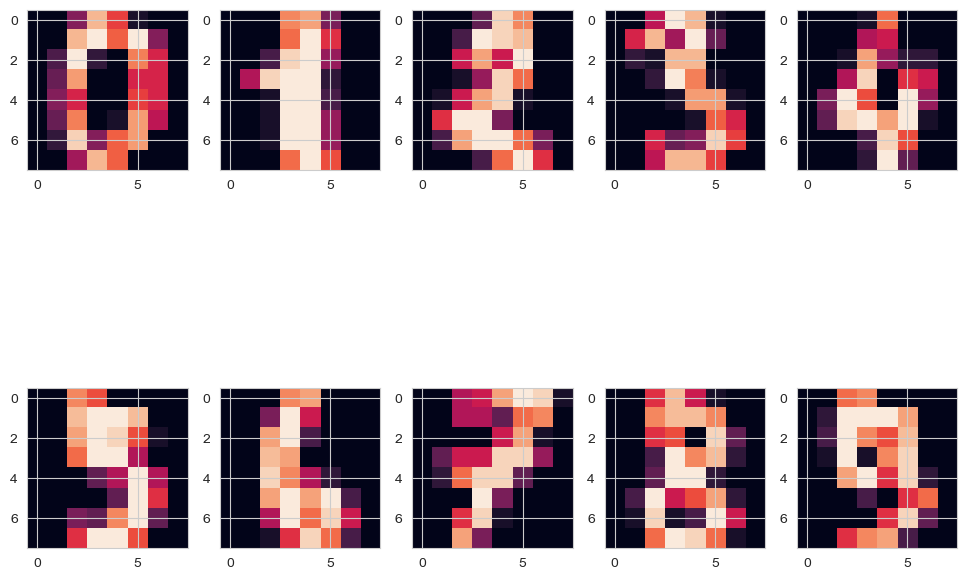

In [52]:
img_list = []

for pic_class in np.unique(y):
    img_list.append(X[y==pic_class][0].reshape(8, 8))


fig, axes = plt.subplots(nrows=2, ncols=5)
axs = axes.flatten()
for img, ax in zip(img_list, axs):
    ax.imshow(img)
    
plt.show()

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [142]:
db = AgglomerativeClustering(linkage='single', metric='euclidean', n_clusters=10)

TypeError: __init__() got an unexpected keyword argument 'metric'

In [157]:
def algorithm_selection(X, distances, algorithms, metrics, n_clust=None, linkage=None, y=None):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithms: алгоритм кластеризации (hierarhical, kmeans, dbscan)
        :param linkage: параметр linkage для иерархической кластеризации ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """
    
    # checking if the input parameters are possible
    if set(algorithms).difference({'hierarchical', 'kmeans'}):
        raise NameError('Incorrect algorithm name!')
    if set(distances).difference({'euclidean', 'manhattan', 'cosine', 'l1', 'l2'}):
        raise NameError('Incorrect distance name!')
    if set(metrics).difference({'homogeneity', 'completeness', 'v_measure', 'silhouette'}):
        raise NameError('Incorrect metric name!')
    if set(linkage).difference({'single', 'complete', 'average'}):
        raise NameError('Incorrect linkage name!')
        
    if (type(y).__module__ != np.__name__) and (len(set(metrics).difference({'silhouette'})) > 0):
        raise KeyError('If you use Ground Truth based metrics you have to pass y!')
    
    # setting the metrics dict   
    metrics_dict = {'homogeneity': homogeneity_score, 'completeness': completeness_score,
                    'v_measure': v_measure_score, 'silhouette': silhouette_score}

    # creating an empty dataframe
    compare_dataframe = pd.DataFrame(columns=['algorithm', 'distance', 'linkage']+metrics)
    
    # function that will calculate all metrics
    def _df_newrow(df, alg, alg_name, linkage = None):
        pred = alg.fit_predict(X)
        
        res_list = [alg_name, dist, linkage]
        for metric in metrics:
            if metric == 'silhouette':
                res_list.append(metrics_dict[metric](X, pred))
            else:
                res_list.append(metrics_dict[metric](y, pred))
        return res_list
        
    
    for alg in algorithms:
        for dist in distances:
            if (alg == 'hierarchical') and (isinstance(linkage, list)):
                for lnk in linkage:
                    compare_dataframe.loc[len(compare_dataframe.index)] = _df_newrow(
                        compare_dataframe, AgglomerativeClustering(linkage=lnk, affinity=dist, n_clusters=n_clust), alg, lnk)
            else:
                compare_dataframe.loc[len(compare_dataframe.index)] = _df_newrow(
                    compare_dataframe, KMeans(n_clusters=n_clust), alg
                )
    
    return compare_dataframe

In [158]:
distances = ['euclidean', 'manhattan', 'cosine', 'l1', 'l2']
linkages = ['average', 'single', 'complete']
metrics = ['homogeneity', 'completeness', 'v_measure', 'silhouette']
algorithms = ['kmeans', 'hierarchical']

alg_compar = algorithm_selection(X, distances, algorithms, metrics, n_clust=10, linkage=linkages, y=y)
alg_compar

algorithm   distance   linkage  homogeneity  completeness  v_measure  \
0         kmeans  euclidean      None     0.742309      0.751522   0.746887   
1         kmeans  manhattan      None     0.737945      0.746615   0.742254   
2         kmeans     cosine      None     0.740640      0.749050   0.744821   
3         kmeans         l1      None     0.740248      0.748643   0.744422   
4         kmeans         l2      None     0.733768      0.741926   0.737824   
5   hierarchical  euclidean   average     0.655393      0.782342   0.713263   
6   hierarchical  euclidean    single     0.005056      0.273755   0.009929   
7   hierarchical  euclidean  complete     0.590549      0.637772   0.613253   
8   hierarchical  manhattan   average     0.566751      0.778942   0.656117   
9   hierarchical  manhattan    single     0.005102      0.276237   0.010019   
10  hierarchical  manhattan  complete     0.646372      0.686109   0.665648   
11  hierarchical     cosine   average     0.648268      0.808762   0.719676   
12  hierarchical     cosine    single     0.005050      0.273389   0.009916   
13  hierarchical     cosine  complete     0.528727      0.577415   0.551999   
14  hierarchical         l1   average     0.566751      0.778942   0.656117   
15  hierarchical         l1    single     0.005102      0.276237   0.010019   
16  hierarchical         l1  complete     0.646372      0.686109   0.665648   
17  hierarchical         l2   average     0.655393      0.782342   0.713263   
18  hierarchical         l2    single     0.005056      0.273755   0.009929   
19  hierarchical         l2  complete     0.590549      0.637772   0.613253   

    silhouette  
0     0.182608  
1     0.182482  
2     0.182436  
3     0.182452  
4     0.182084  
5     0.146625  
6    -0.133621  
7     0.119271  
8     0.089217  
9    -0.166627  
10    0.140183  
11    0.129526  
12   -0.158250  
13    0.088021  
14    0.089217  
15   -0.166627  
16    0.140183  
17    0.146625  
18   -0.133621  
19    0.119271

We can see that the best model is Kmeans, but among hierarhical models, the least suitable linkage is single, and the most suitable distance is cosine. 

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [18]:
fc_data = pd.read_csv("./data/flow_c_data.csv", index_col=0)

##### YOUR TURN TO CODE:

In [19]:
fc_data.head()

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0  0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1  0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2  1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3  0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4  0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   

       CD19     CD11c  
0 -1.406912  0.384406  
1  6.034845  0.577039  
2 -0.318668 -0.493832  
3  0.694883  3.416960  
4  5.563345  0.471591

In [21]:
fc_data.shape

(10000, 9)

In [20]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

The dataset has 10000 samples and 9 parameters-genes. We can see that even though std and means seems to be not that different, we'd better do normalization to make it more clear within a range of 0-1. We can also can notice suspiciously high max values for some columns. To visualise it we will build some plots:

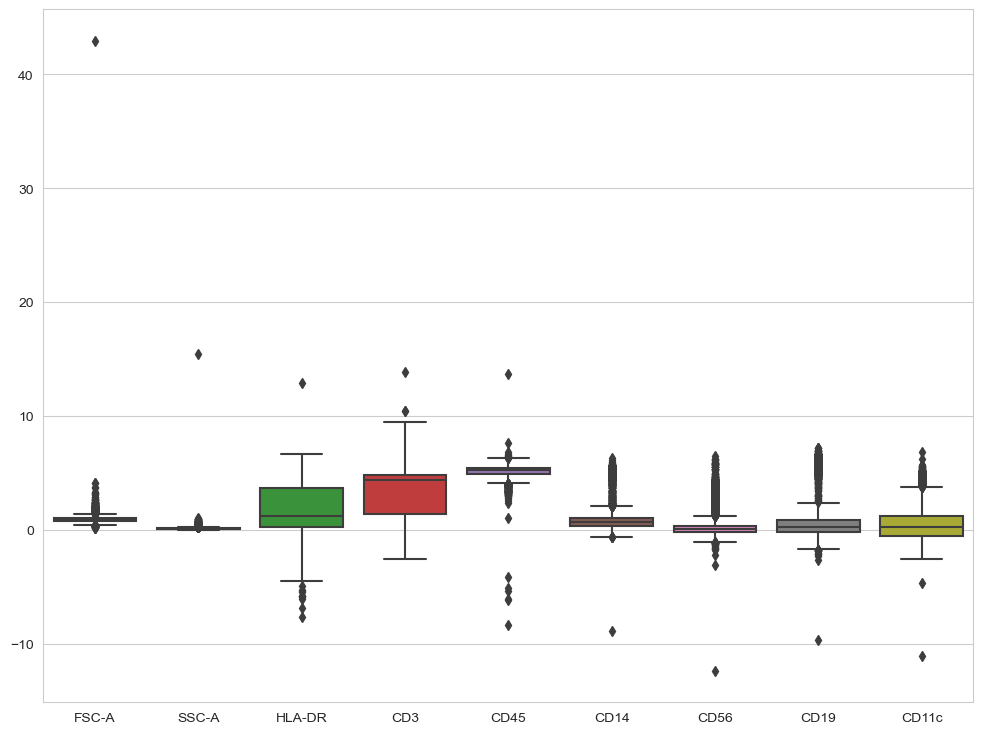

In [35]:
sns.boxplot(data=fc_data);

Indeed, we have big positive outliers in the first 5 columns and some negative outliers in the last 4 genes. 

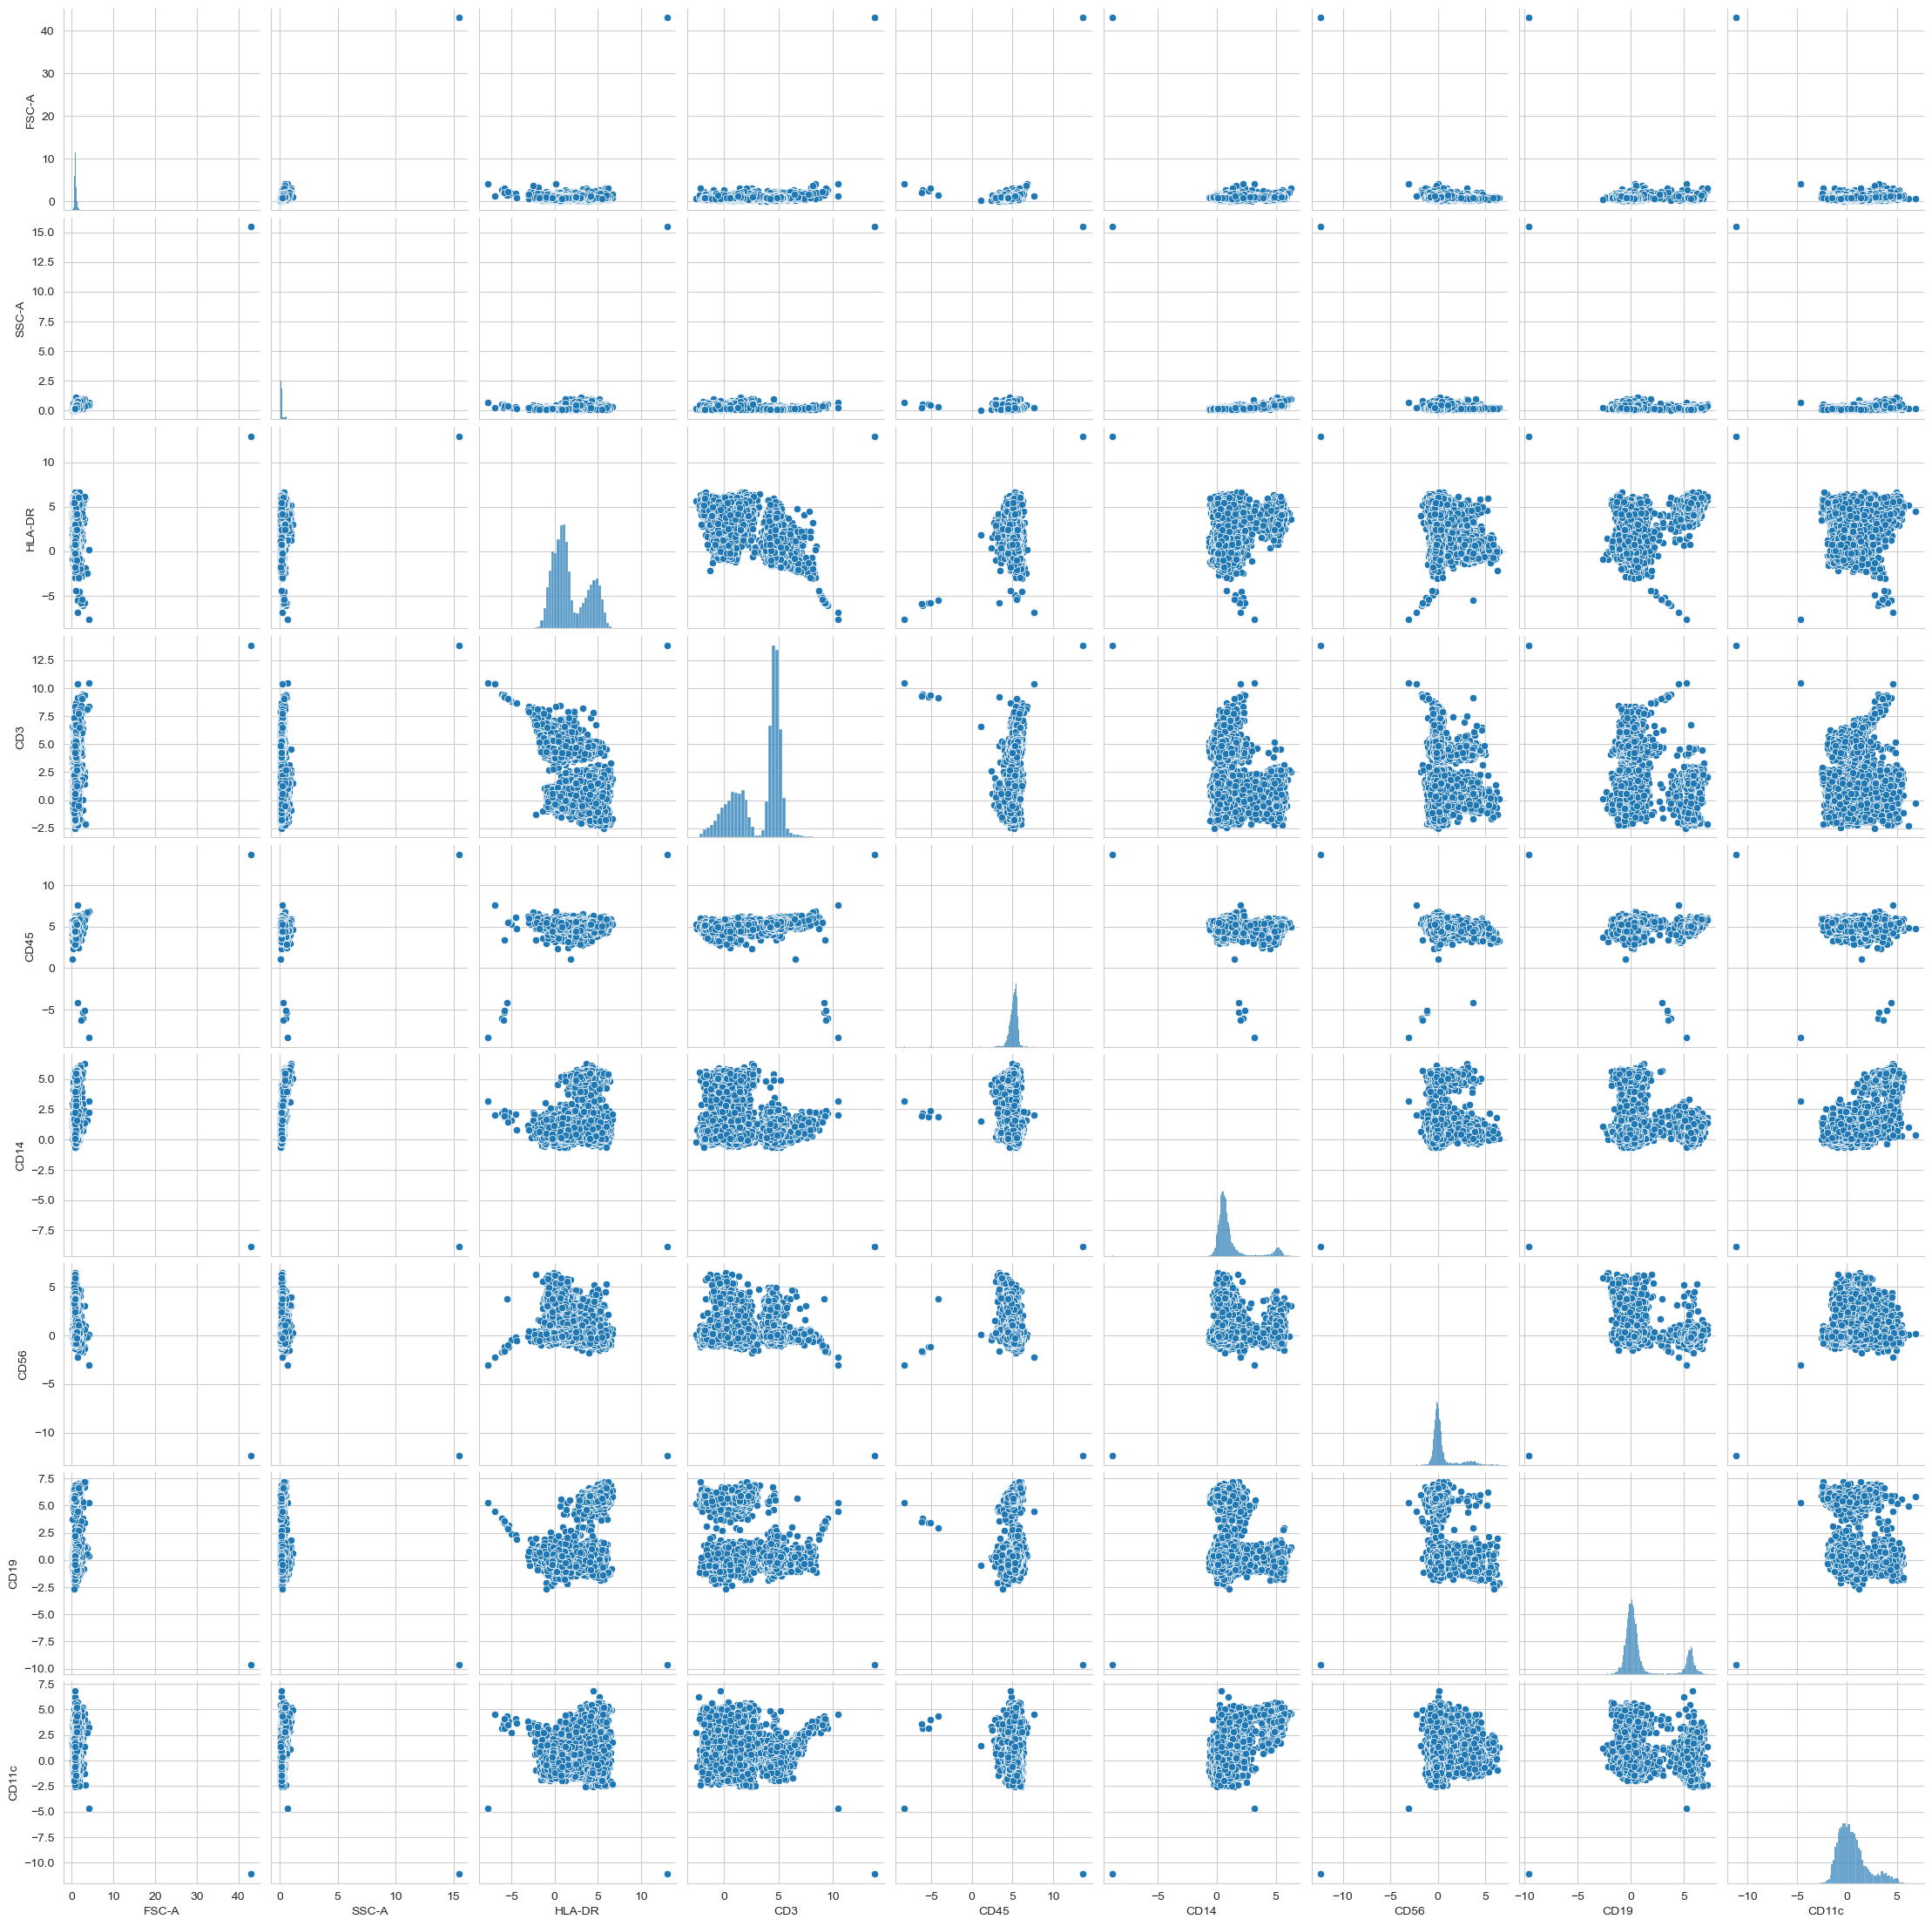

In [37]:
sns.pairplot(fc_data)

The columns relationships from this plot are not clear - we have some correlations in the zone of small values of HLA-DR and in the big values of CD3. CD19-CD14 and CD19-CD14 looks like flying alpacas :3
The one outlier is also very noticeable in the corner of many plots.

In [161]:
# deleting the outlier

fc_data = fc_data.drop(labels=[np.argmax(fc_data['FSC-A']), np.argmax(fc_data['CD3']), np.argmin(fc_data['CD14']),
                                     np.argmin(fc_data['CD56']), np.argmin(fc_data['CD45'])], axis=0, inplace=False)

# normalization 

scaler = StandardScaler()
fc_data_norm = pd.DataFrame(scaler.fit_transform(fc_data), columns=fc_data.columns)

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [185]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

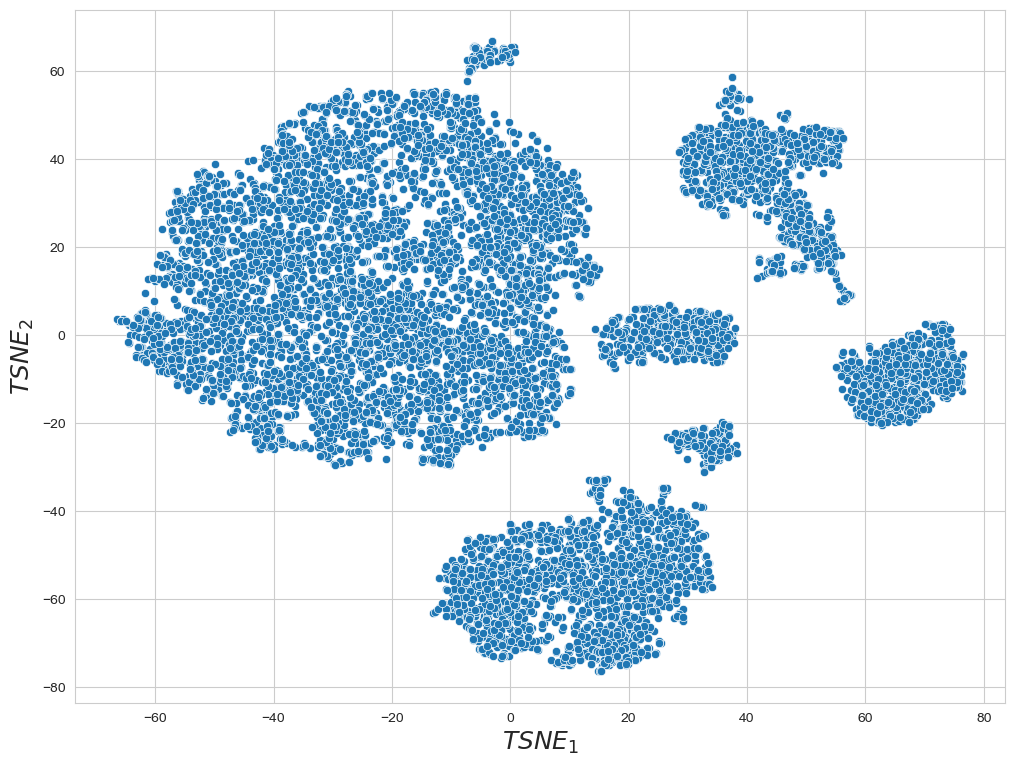

In [186]:
tsne_res = plot_tsne(fc_data_norm)

As we can clearly see on the plot, we have 5 clusters in our data. So we will use this parameter for clustering.

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

Here we will apply K-means, DBSCAN and hierarchical clustering:

### K-means

In [194]:
km = KMeans(n_clusters=5, random_state=SEED)

In [195]:
pred_km = km.fit_predict(fc_data_norm) 
silhouette_score(fc_data_norm, pred_km)

0.5193758771242496

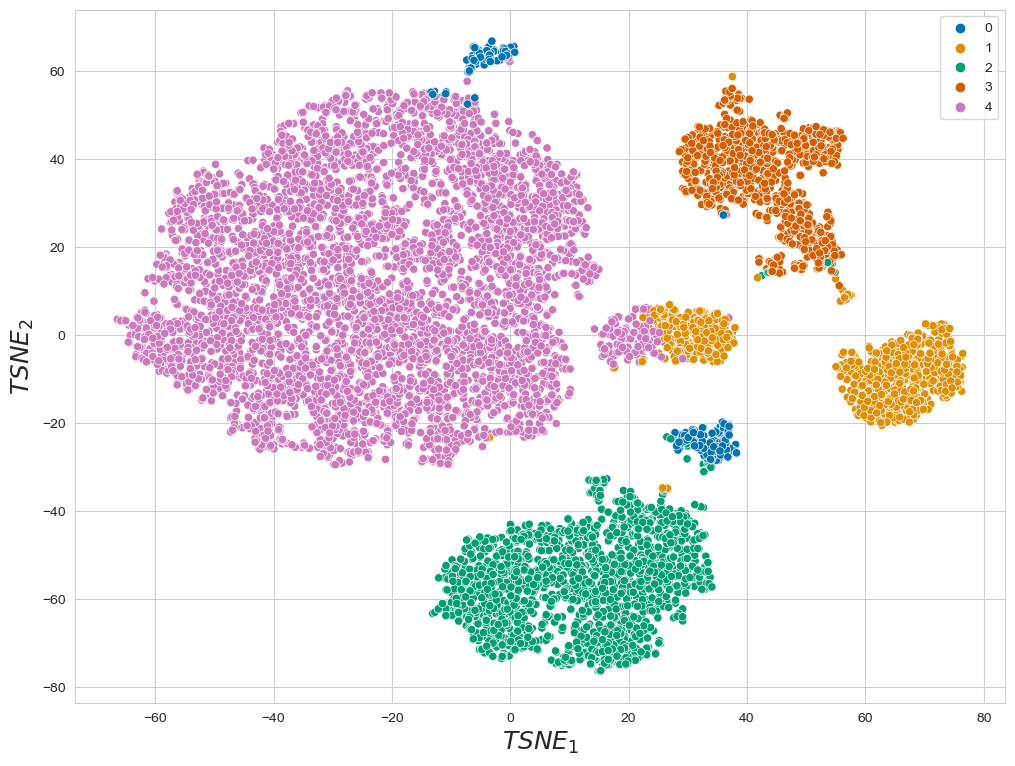

In [196]:
plot_tsne(fc_data_norm, color=pred_km);

### DBSCAN:

In [180]:
for eps in [1, 2, 3, 5, 8]:
    for ms in [2, 3, 5, 8, 10, 15, 20]:
        pred_dbscan = DBSCAN(eps=eps, min_samples=ms).fit_predict(fc_data_norm)
        print('eps: ', eps, 'min_samples: ', ms, 'score: ', silhouette_score(fc_data_norm, pred_dbscan))

eps:  1 min_samples:  2 score:  0.02409270443386755
eps:  1 min_samples:  3 score:  0.13825374263638807
eps:  1 min_samples:  5 score:  0.3751609679904827
eps:  1 min_samples:  8 score:  0.42510804687922693
eps:  1 min_samples:  10 score:  0.42063810641478616
eps:  1 min_samples:  15 score:  0.43290016334368603
eps:  1 min_samples:  20 score:  0.42442578942583187
eps:  2 min_samples:  2 score:  0.4840811990800184
eps:  2 min_samples:  3 score:  0.4840453090482825
eps:  2 min_samples:  5 score:  0.6157558667578353
eps:  2 min_samples:  8 score:  0.5933767528102473
eps:  2 min_samples:  10 score:  0.5857091797423976
eps:  2 min_samples:  15 score:  0.4813338585369746
eps:  2 min_samples:  20 score:  0.4814124155688136
eps:  3 min_samples:  2 score:  0.6831681773024827
eps:  3 min_samples:  3 score:  0.6831681773024827
eps:  3 min_samples:  5 score:  0.7461964220470618
eps:  3 min_samples:  8 score:  0.7325535472021965
eps:  3 min_samples:  10 score:  0.7325535472021965
eps:  3 min_sample

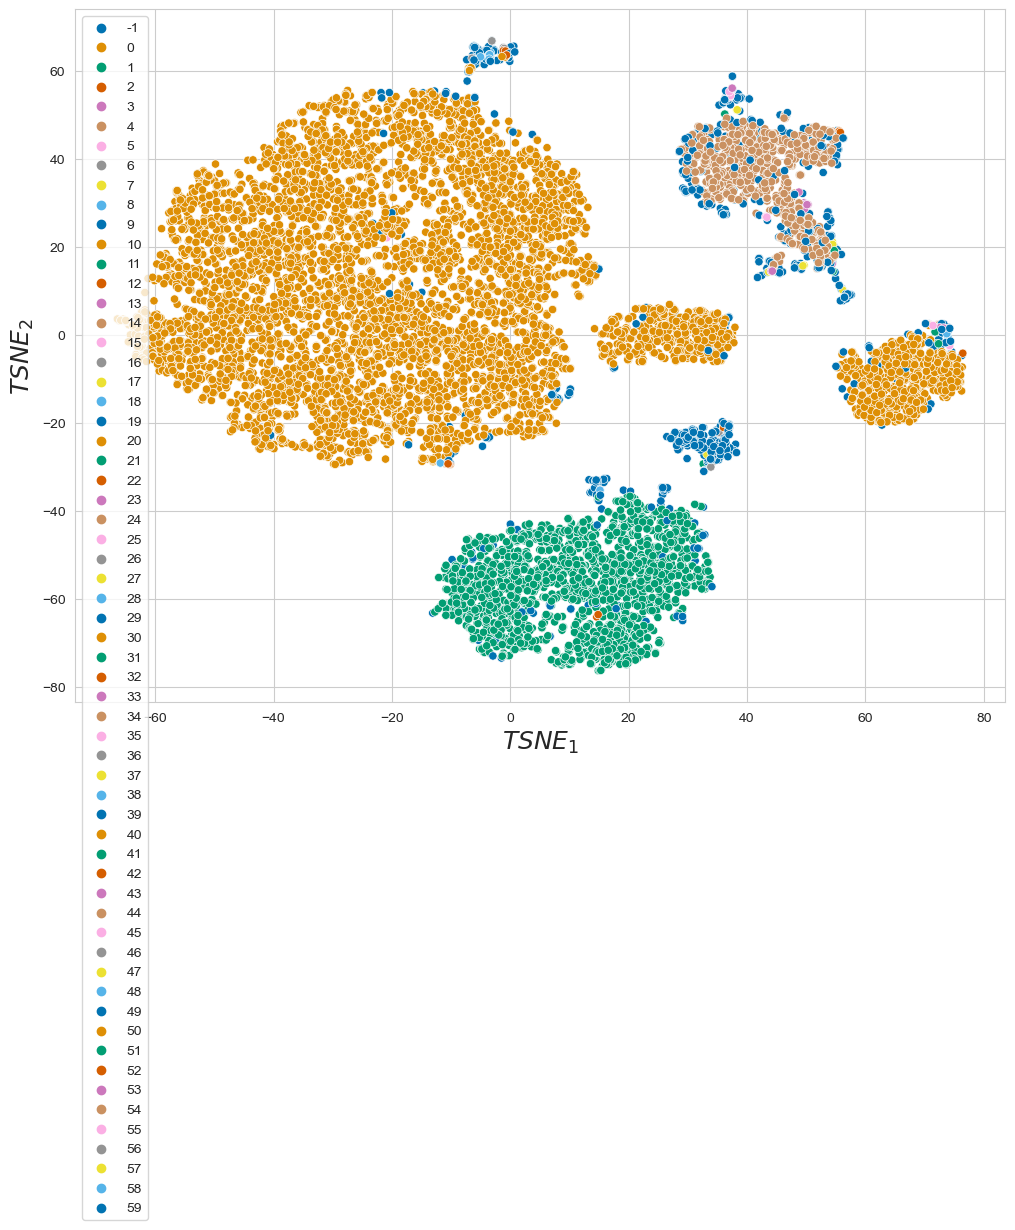

In [183]:
pred_dbscan = DBSCAN(eps=1, min_samples=2).fit_predict(fc_data_norm)
plot_tsne(fc_data_norm, color=pred_dbscan);

### Hierarchical:

In [170]:
for dist in ['euclidean', 'manhattan', 'cosine', 'l1', 'l2']:
    pred_h = AgglomerativeClustering(n_clusters=5, affinity=dist, linkage='average').fit_predict(fc_data_norm)
    print(dist, silhouette_score(fc_data_norm, pred_h))

euclidean 0.5559508227260799
manhattan 0.4876548050271834
cosine 0.4812512549877487
l1 0.4876548050271834
l2 0.5559508227260799


Euclidean and l2 performs better

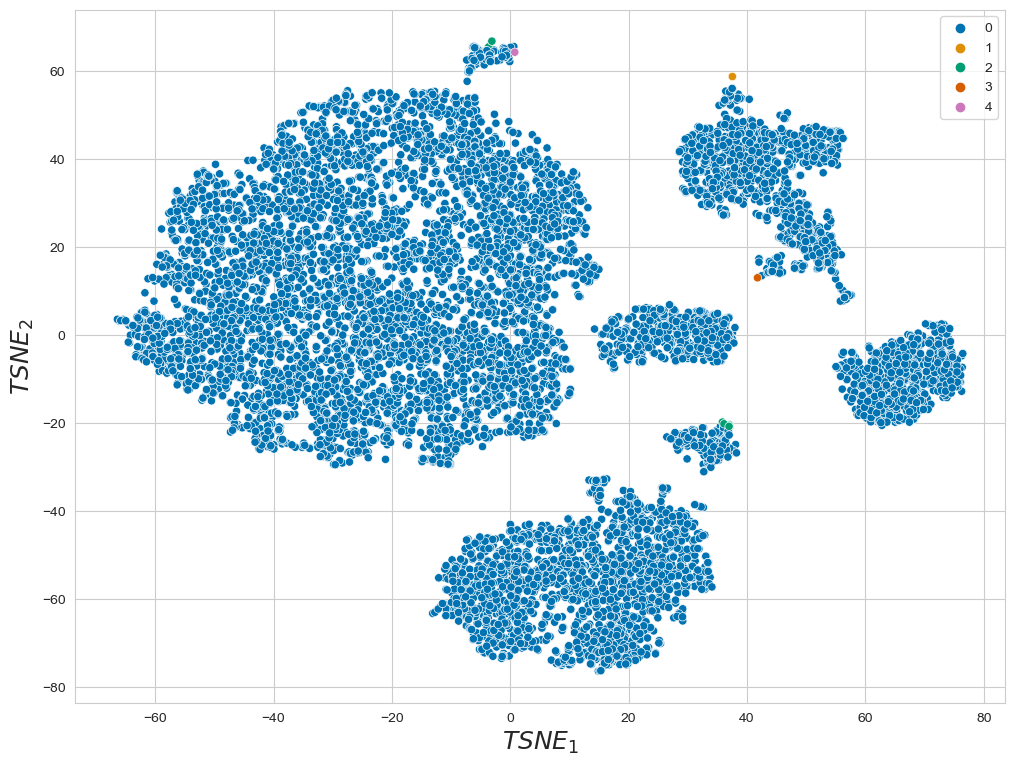

In [174]:
plot_tsne(fc_data_norm, color=pred_h);

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

Overall, we can see that Kmeans are working really good, leaving just small groups with uncorrect cluster. Hierarhical clusterisation seems like not working at all, maybe we have to look through the wider range of hyperparameters. DBSCAN required a bit more accurate selection of hyperparameters, but on the plot we can see that it still was able to identify several main clusters.

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

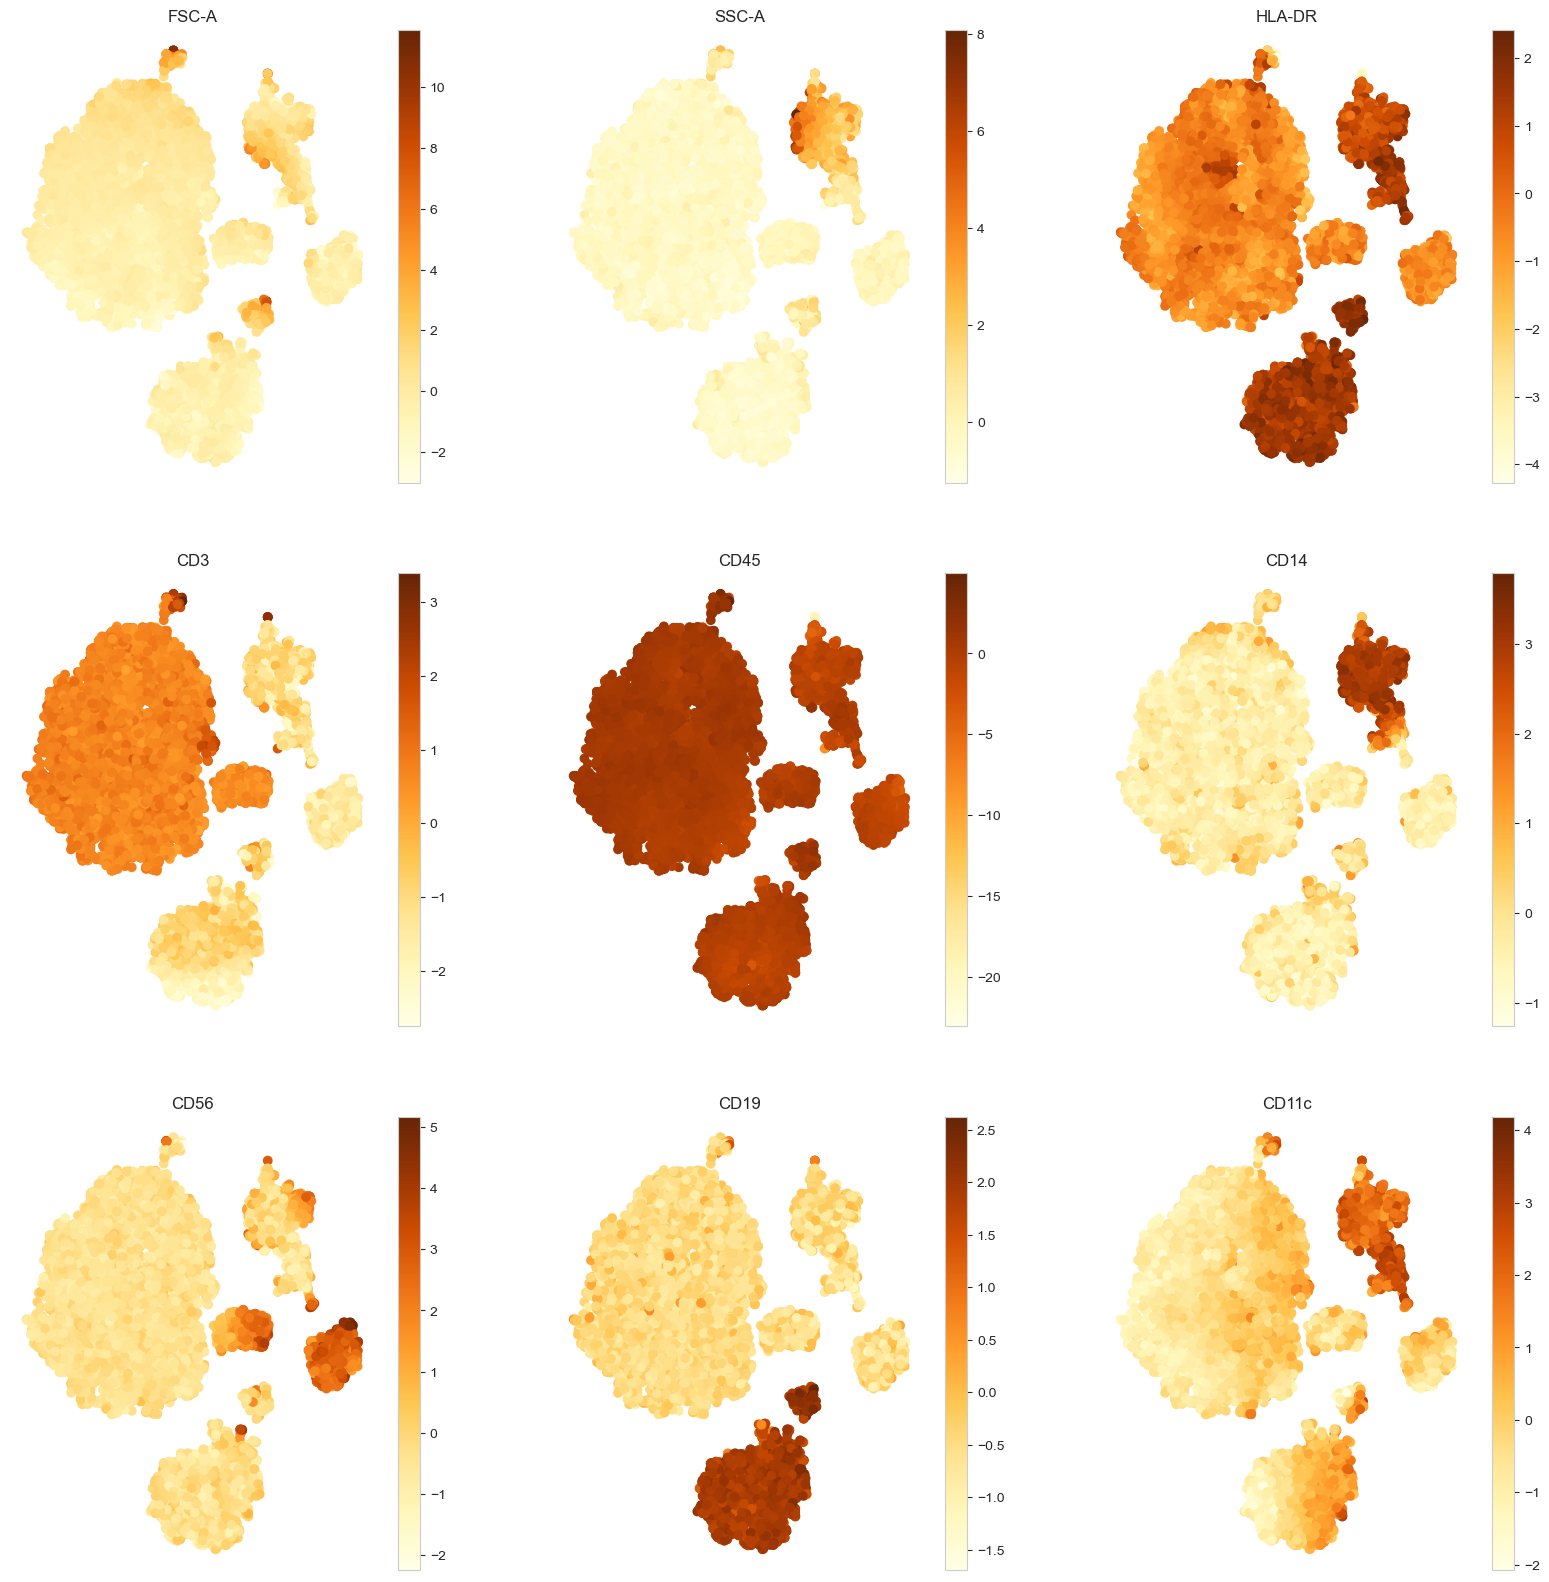

In [187]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data_norm.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data_norm[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

We know that typical markers for the cell types are: CD14 from monocytes, CD19 for B-cells, and CD3 for T-cells. Also as we can see the cluster 1 on kmeans result has high expression of CD56, so probably it is nk-cells.

In [189]:
cell_type_cluster_map = {0: 'other', 
                         1: 'nk_cels', 
                         2: 'b_cells', 
                         3: 'monocytes',
                         4: 't_cells'}

In [197]:
labeled_fc_data = fc_data_norm.assign(Population=km.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [198]:
labeled_fc_data.head()

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0 -0.874440 -0.084521 -0.641092 -1.311944 -2.257207 -0.057699  3.071914   
1 -0.767342 -0.432299  1.425104 -1.165299 -0.481045 -0.684311 -0.539131   
2  0.557214 -0.121578 -1.094796  0.344990  0.904553 -0.422088  0.315380   
3 -1.500857 -0.385674 -0.714532  0.025298  0.183704  0.278956 -0.127683   
4 -0.679028 -0.762686  1.579934 -1.135201 -1.232989 -0.642242 -0.280348   

       CD19     CD11c Population  
0 -1.150990 -0.125202    nk_cels  
1  2.110462  0.003465    b_cells  
2 -0.674053 -0.711805    t_cells  
3 -0.229850  1.900341    t_cells  
4  1.903820 -0.066968    b_cells

In [199]:
labeled_fc_data["Population"].value_counts()

t_cells      5810
b_cells      1873
monocytes    1062
nk_cels       972
other         277
Name: Population, dtype: int64

We can see that there is a big shift towards t-cells.

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [200]:
labeled_fc_data.to_csv("./labeled_cells.csv")

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

In [205]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

Train-test split, let's take 30% as test:

In [202]:
X = labeled_fc_data.drop("Population", axis=1)
y = labeled_fc_data['Population']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

Let's use KNN classifier for this task. So we'll have to chose the best number of neighbors:

In [208]:
k_list = [2, 3, 4, 5, 8, 10, 15, 30]

train_res, test_res = [], []
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred_test = knn.predict(X_test)
    pred_train = knn.predict(X_train)
    test_res.append(f1_score(y_test, pred_test, average="macro"))
    train_res.append(f1_score(y_train, pred_train, average="macro"))  

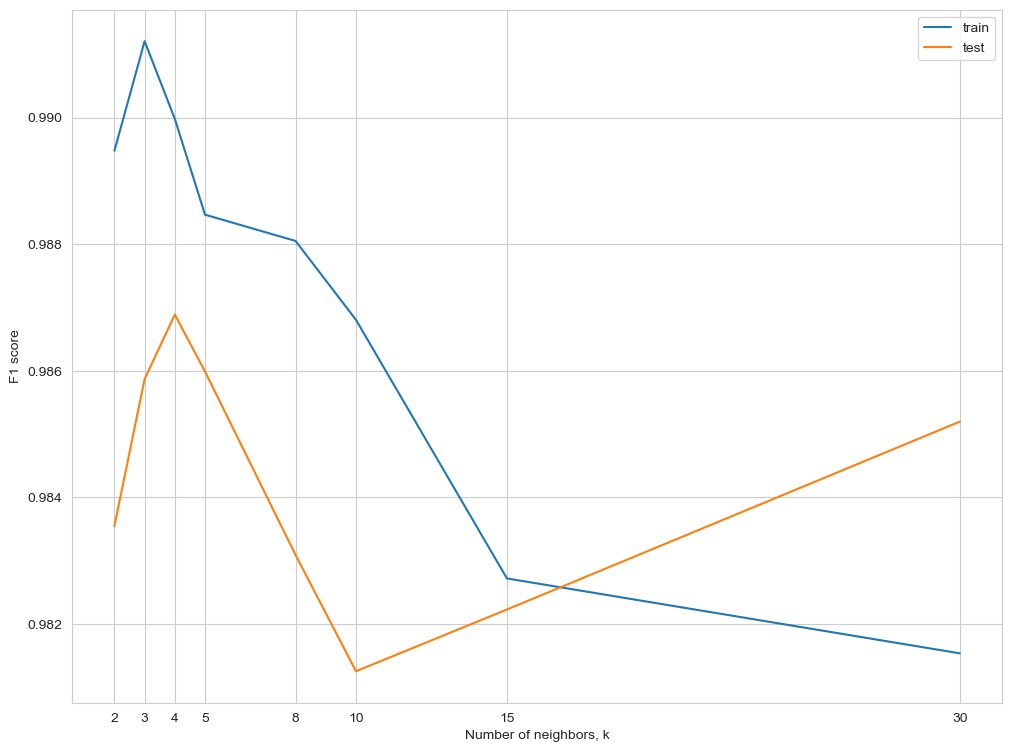

In [215]:
sns.lineplot(k_list, train_res, label="train")
sns.lineplot(k_list, test_res, label="test");
plt.xticks(k_list)
plt.xlabel("Number of neighbors, k")
plt.ylabel("F1 score");

plt.legend()

As we can see the best resut on the test sample was for 4 neighbors, 0.986 - not the best but decent.

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Очень хочу сходить в поход на Алтай или по Саянам - живу мечтами о голубых озерах и заснеженных вершинах! Правда в обоих местах еще очень холодно весной и совсем не зелено.. так что это скорее планы на лето :)

Прошлым летом была на Камчатке - просто ВАУ, к сожалению, были там не очень долго, так что совершенно точно вернусь еще!

Немного фоточек с Камчатки:

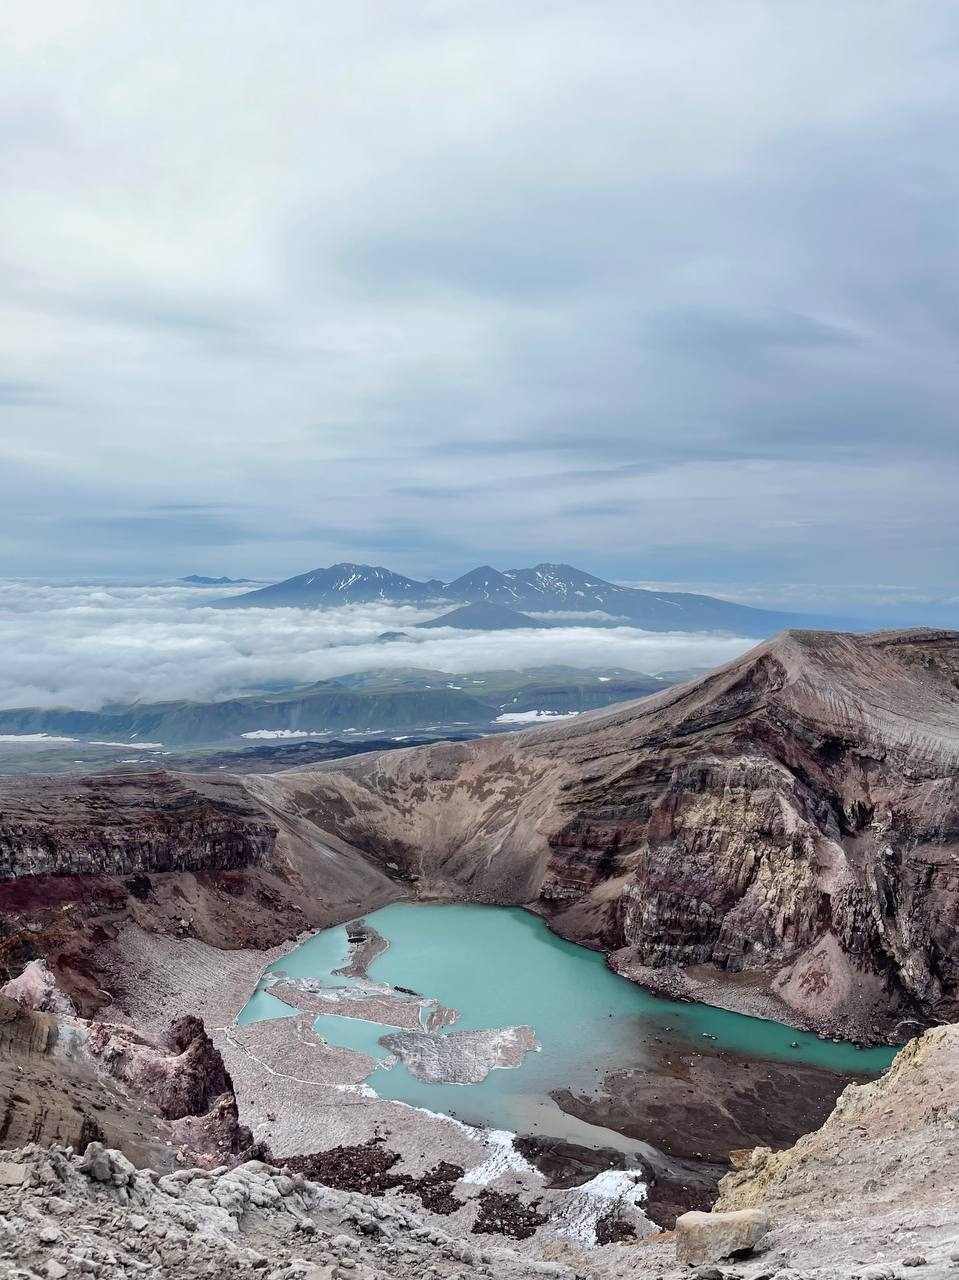

In [216]:
from IPython.display import Image
Image("IMG_1245.jpg") 

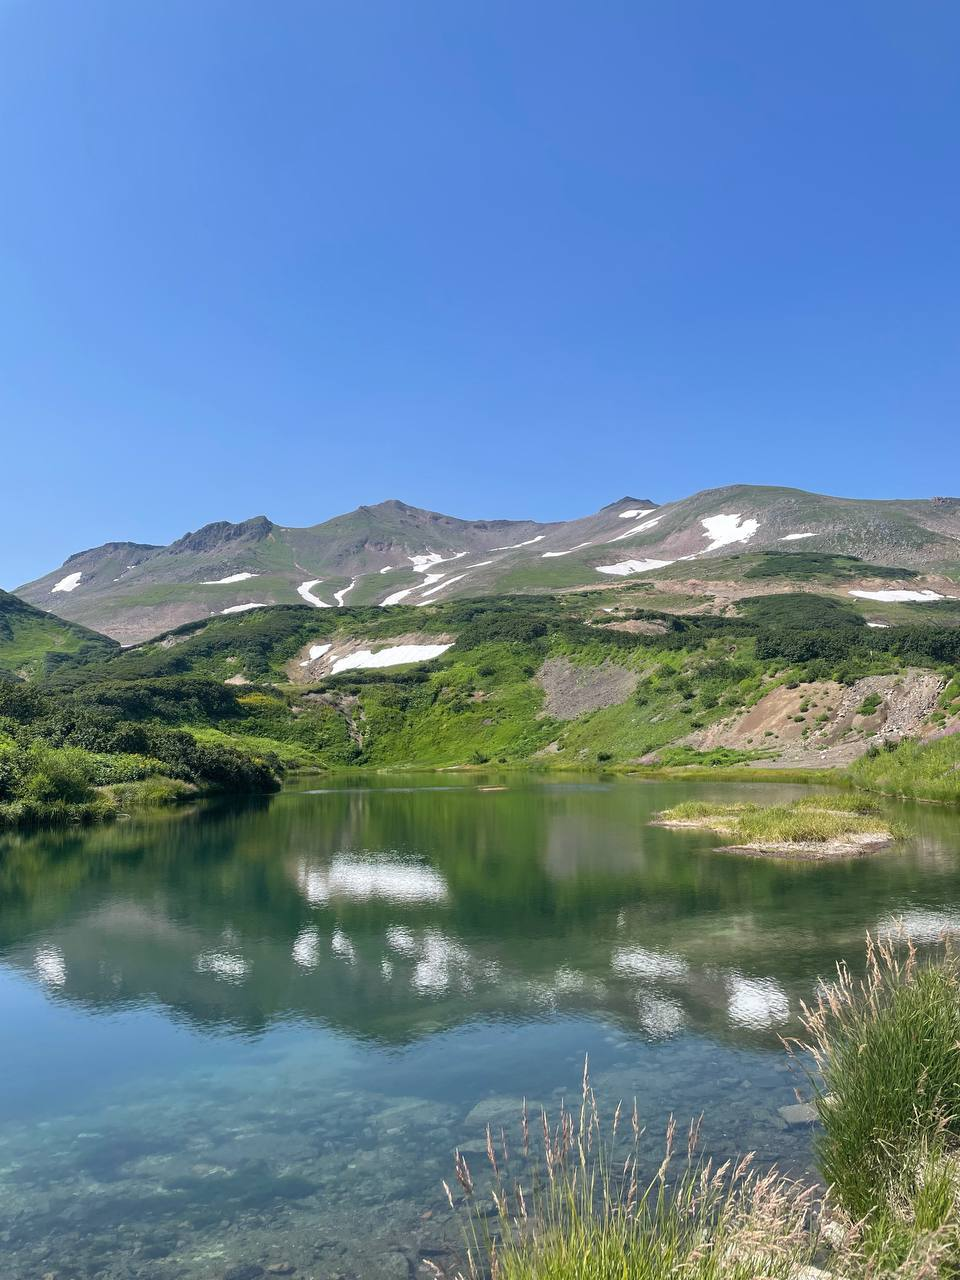

In [217]:
Image("IMG_1240.jpg") 

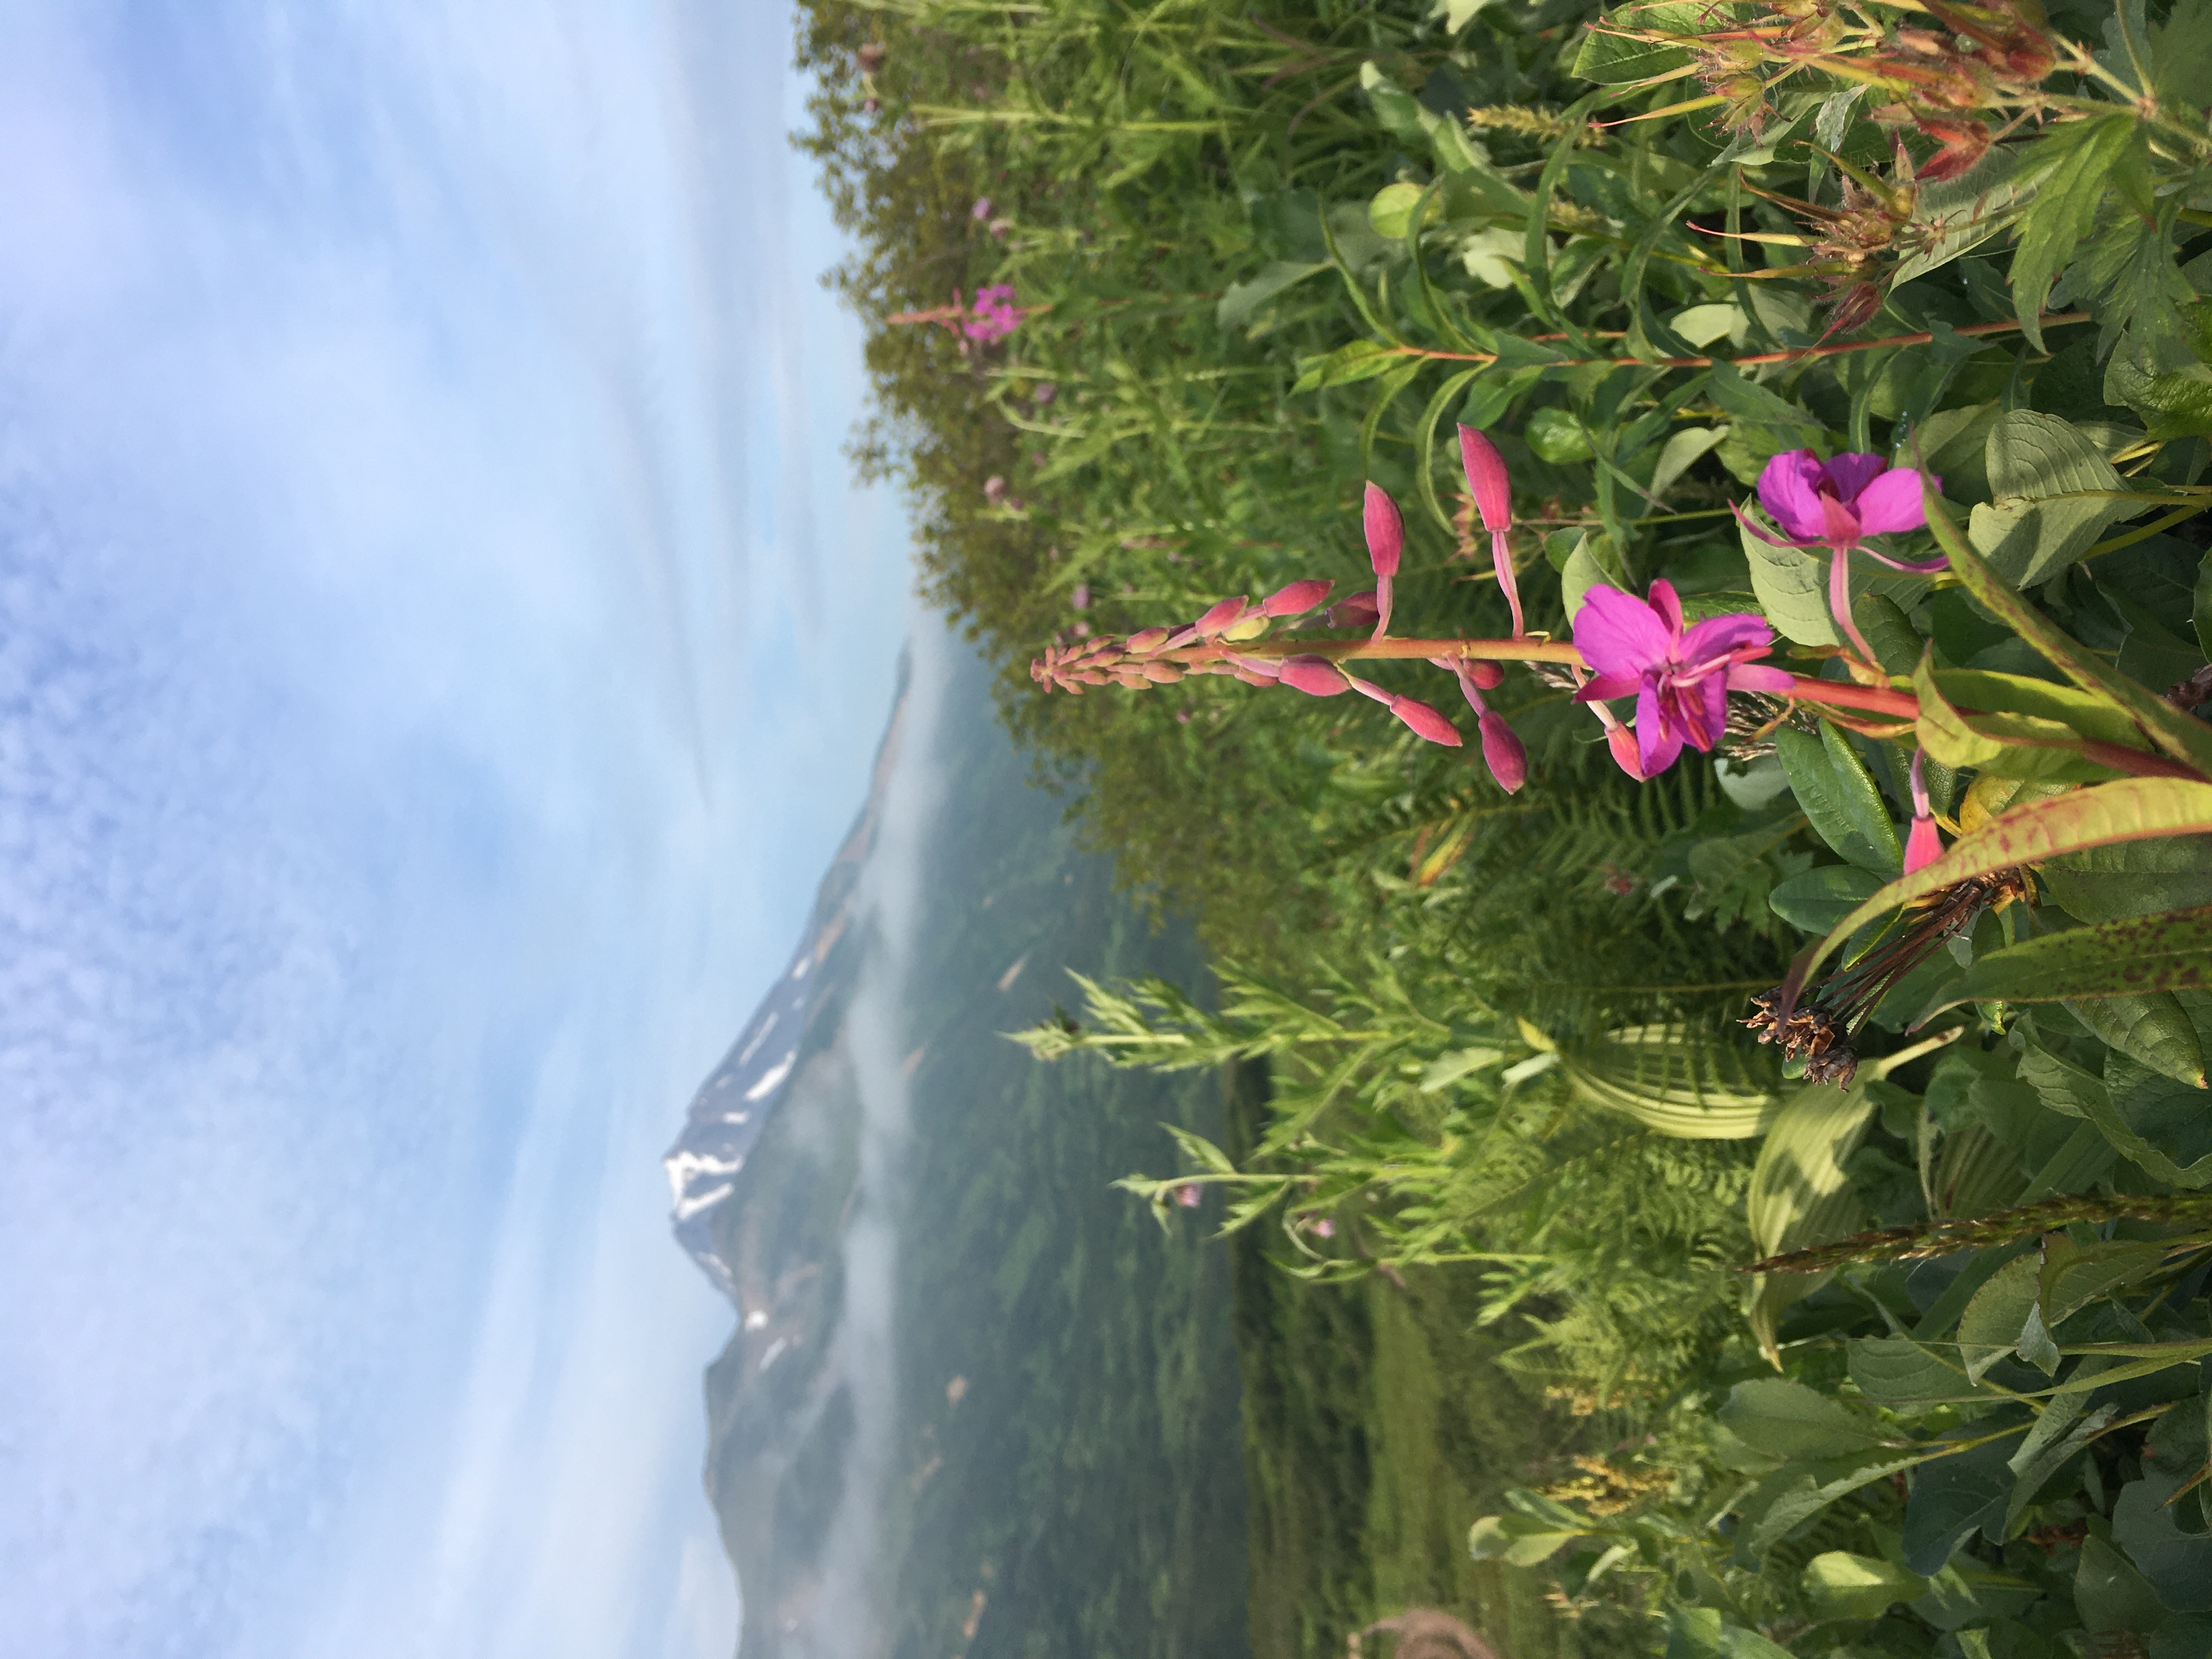

In [218]:
Image("IMG_1151.jpg") 

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**